# global_mechanisms

In this tutorial, we will use the list of MNV in 15,708 genomes from gnomAD dataset to explore the global mechanisms of MNV.
(We are using the word "global", since we do not distinguish coding / non-coding / functional / non-functional regions here.
On the other hand, in the next tutorial `per_region_mechanisms.ipynb`, we will be looking at the MNV distributions stratified by different functional annotation in the genome.)


## Loading the MNV data

The list of non-coding MNVs are available at the google cloud public repository (`gs://gnomad-public/release/2.1/mnv/genome/`), and also at the download page of the browser (https://gnomad.broadinstitute.org/downloads). 

In this tutorial, we will use `read_table` function of hail to read the data:

In [2]:
import hail as hl
import hail.expr.aggregators as agg

d = 1 #we will focus on mnv of distance 1 for most part of this tutorial
mnvs = hl.read_table("gs://gnomad-public/release/2.1/mnv/genome/gnomad_mnv_genome_d{0}.ht".format(d))

Initializing Spark and Hail with default parameters...
Running on Apache Spark version 2.2.3
SparkUI available at http://10.128.0.22:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.12-13681278eb89
LOGGING: writing to /home/hail/hail-20190410-0452-0.2.12-13681278eb89.log


In [3]:
mnvs.show(5) #showing first 5 rows

locus,refs,alts,distance,snp1,snp2,ac1,ac2,ac_mnv,ac1_adj,ac2_adj,ac_mnv_adj
locus<GRCh37>,str,str,int32,str,str,int32,int32,int32,int32,int32,int32
1:10247,"""T,A""","""C,T""",1,"""1-10247-T-C""","""1-10248-A-T""",23,19,4,3,3,0
1:14409,"""G,C""","""A,A""",1,"""1-14409-G-A""","""1-14410-C-A""",1,1,1,1,1,1
1:17928,"""T,C""","""A,A""",1,"""1-17928-T-A""","""1-17929-C-A""",190,190,190,18,17,16
1:23357,"""C,A""","""A,G""",1,"""1-23357-C-A""","""1-23358-A-G""",326,326,326,46,48,46
1:28592,"""T,T""","""G,G""",1,"""1-28592-T-G""","""1-28593-T-G""",2008,2000,2000,25,19,19


In [4]:
mnvs.count() #counting the number of rows and cols

1287642

With this 1,287,642 MNVs that are next to each other, we can start digging into the biology!

## Overview of MNV pattern
First, let's simply look at the patterns of reference and alternative 2 bp (We will call this as "MNV pattern")

In [5]:
def get_cnt_matrix(mnv_table, region="ALL", dist=1):
    # mnv_table = hail table of mnvs
    # region = bed file, defining the regions of interest (e.g. enhancer region)
    # dist = distance between two SNPs
    # filter by region, if you give a bed file path as region
    if region != "ALL":
        bed = hl.import_bed(region)
        mnv_table = mnv_table.filter(hl.is_defined(bed[mnv_table.locus]))
    # count MNV occurance -- restricting to SNPs
    mnv = mnv_table.filter(mnv_table.distance == dist)  # filter to that specific distance
    mnv_cnt = mnv.group_by("refs", "alts").aggregate(cnt=agg.count())  # count occurance
    return (mnv_cnt.key_by().select("refs", "alts", "cnt"))

h = get_cnt_matrix(mnvs, dist=1)

In [6]:
h.show() #Now we have the count per MNV pattern.

2019-04-10 04:53:23 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:53:29 Hail: INFO: Ordering unsorted dataset with network shuffle


refs,alts,cnt
str,str,int64
"""A,A""","""C,C""",3422
"""A,A""","""C,G""",3261
"""A,A""","""C,T""",2197
"""A,A""","""G,C""",4976
"""A,A""","""G,G""",9159
"""A,A""","""G,T""",4700
"""A,A""","""T,C""",2140
"""A,A""","""T,G""",3248
"""A,A""","""T,T""",13651


We are going to turn this into pandas dataframe for easier visualization:

In [7]:
import pandas as pd
def ht_cnt_mat_to_pd(ht_cnt_mat):
    pds = ht_cnt_mat.to_pandas()
    pds.fillna(value=0, inplace=True)
    pds = pd.pivot_table(pds, index="refs", columns="alts")
    pds.fillna(value=0, inplace=True)
    pds.columns = pds.columns.get_level_values(1)  # to set the columns name properly.
    return (pds) #returning the pandas table
pds = ht_cnt_mat_to_pd(h)
display(pds)

2019-04-10 04:53:35 Hail: INFO: Ordering unsorted dataset with network shuffle


alts,"A,A","A,C","A,G","A,T","C,A","C,C","C,G","C,T","G,A","G,C","G,G","G,T","T,A","T,C","T,G","T,T"
refs,,,,,,,,,,,,,,,,
"A,A",0.0,0.0,0.0,0.0,0.0,3422.0,3261.0,2197.0,0.0,4976.0,9159.0,4700.0,0.0,2140.0,3248.0,13651.0
"A,C",0.0,0.0,0.0,0.0,4268.0,0.0,1375.0,5669.0,6156.0,0.0,4164.0,22390.0,3167.0,0.0,1883.0,6968.0
"A,G",0.0,0.0,0.0,0.0,16761.0,6616.0,0.0,4400.0,11764.0,4461.0,0.0,6075.0,4173.0,2203.0,0.0,4315.0
"A,T",0.0,0.0,0.0,0.0,2055.0,3565.0,1118.0,0.0,4017.0,14845.0,3573.0,0.0,5691.0,4186.0,2085.0,0.0
"C,A",0.0,4348.0,14433.0,5332.0,0.0,0.0,0.0,0.0,0.0,1687.0,8791.0,1690.0,0.0,4091.0,137076.0,5852.0
"C,C",12251.0,0.0,5577.0,9459.0,0.0,0.0,0.0,0.0,3813.0,0.0,2823.0,6779.0,5446.0,0.0,17788.0,18986.0
"C,G",5003.0,1186.0,0.0,1110.0,0.0,0.0,0.0,0.0,3780.0,1185.0,0.0,1155.0,24491.0,3761.0,0.0,5070.0
"C,T",4304.0,6064.0,4459.0,0.0,0.0,0.0,0.0,0.0,2164.0,4510.0,6548.0,0.0,4238.0,11805.0,16690.0,0.0
"G,A",0.0,6566.0,18912.0,13470.0,0.0,1586.0,3245.0,3795.0,0.0,0.0,0.0,0.0,0.0,3964.0,5738.0,18570.0


Now we can clearly see the number of MNVs per MNV pattern. 
Let's actually use heatmap to effectively visualize this (supp. fig 3a, and 4): 

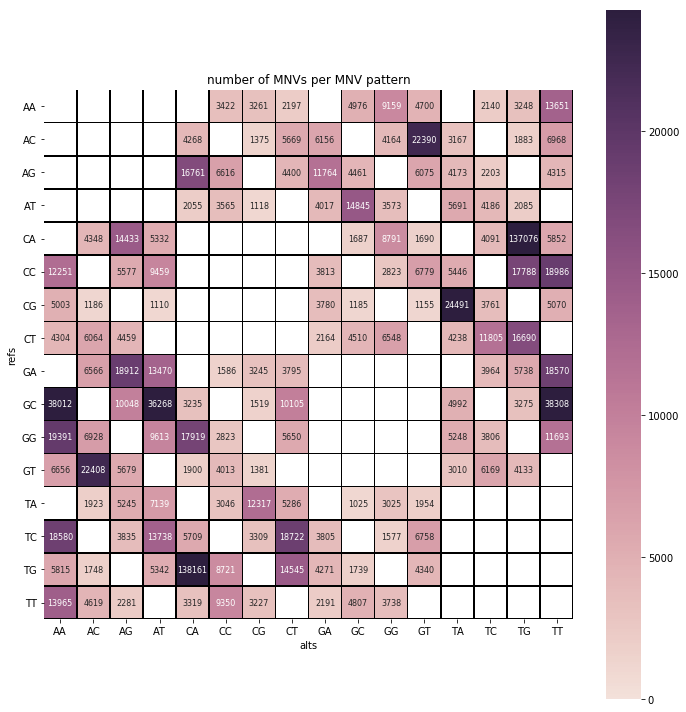

In [8]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_heatmap(crstb, title, num_style="d", num_size=8, rotx=0): #num_style: d, f etc
    mask = crstb.applymap(lambda x: x == 0) #mask those cell with 0 counts
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_aspect('equal')
    cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
    ax = sns.heatmap(crstb, robust=True, linewidths=.5, annot=True,cmap=cmap,
                     annot_kws={"size": num_size}, fmt=num_style, mask=mask, linecolor="black")
    #ax.set(axis_bgcolor='#bbbbbbff')
    ax.set_title(title)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotx)
    ax.set_ylabel("refs")
    ax.set_xlabel("alts")
    plt.tight_layout()
    plt.show()
pds.index = pds.index.str.replace(",","") #to explicitly show that we are looking at MNV of distance=1
pds.columns = pds.columns.str.replace(",","") #to explicitly show that we are looking at MNV of distance=1
pds = pds.applymap(lambda x: int(x))

draw_heatmap(pds, "number of MNVs per MNV pattern")

(It is almost clear to the readers that we can simply do the same thing by replacing the single line `d=1` to `d=i` (1<i<11) 
to reproduce the same result for MNVs of longer distance. That is exactly what supp. fig 4 is. We will leave it as an user excercise!)

In the main peper, we have explained three different mechanisms for MNV. 


Looking at the number of MNV itself, we can find the highly different frequency of MNVs by the mechanism:

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


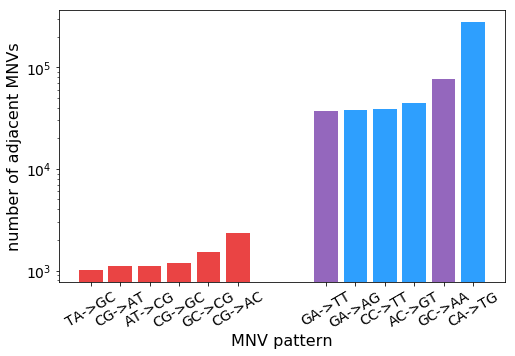

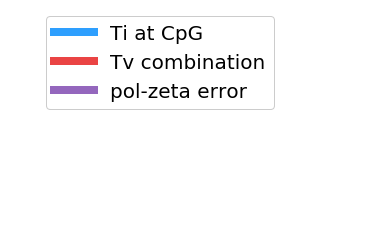

In [9]:
col_dict={"CpG_Ti":"#2E9FFEFF","Ti":"#2ca02cff","Tv":"#EA4444ff","repeat":"#8c564bFF","pol zeta":"#9467bdff","TiTv":"#888888ff","CpG_Ti_Tv":"#111e6cff"}
dnv = collapse_crstb_to_revcomp(pds) #this function to collapse the reverse complement, is defined in the end
dnv = dnv.sort_values(by="cnt").reset_index()
names = dnv.refs + "->" + dnv.alts
dnv.index = names
toplot = pd.concat([dnv.cnt.head(6), dnv.cnt.tail(6)])
#prepare color, manually, based on the known mechanisms
cols_class=["Tv"]*6+["pol zeta","CpG_Ti","CpG_Ti","CpG_Ti","pol zeta","CpG_Ti"]
cols = []
for c in cols_class:
    cols.append(col_dict[c])
x = [1,2,3,4,5,6,9,10,11,12,13,14]
plt.figure(figsize=(8,5))
plt.bar(x, toplot, color=cols, log=True)
plt.xticks(x, toplot.index.values, fontname="Microsoft Sans Serif", rotation=30, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("number of adjacent MNVs", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("MNV pattern", fontname="Microsoft Sans Serif", size=16)
plt.show()

#just to add legend, outside of the figure:
plt.plot([0,0], [1,1],color=col_dict["CpG_Ti"],label="Ti at CpG")
plt.plot([0,0], [1,1],color=col_dict["Tv"],label="Tv combination")
plt.plot([0,0], [1,1],color=col_dict["pol zeta"],label="pol-zeta error")
leg = plt.legend(loc="upper left", fontsize=20, framealpha=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
plt.axis('off')
plt.show()

## Mechanism 1. Distinct single nucleotide substitution events

In order to show that frequency of the MNV pattern roughly follows what we understand from SNV mutation rate, 
let's first visualize the expected number of MNVs based on a simple model which assumes all the MNVs are simple combination of SNV.
(See )
("roughly" is because we know there are exceptions, as in mechanism 2 and 3.)

In [10]:
with hl.hadoop_open("gs://gnomad-public/release/2.1/mnv/resources/genome_null_wgs_nonsq.tsv", 'r') as f:
        prob_mat_dnv_null = pd.read_csv(f,sep="\t", index_col=0) #probability based on SNV model
num_mat_dnv_null = prob_mat_dnv_null * dnv["cnt"].sum() / prob_mat_dnv_null.sum().sum()

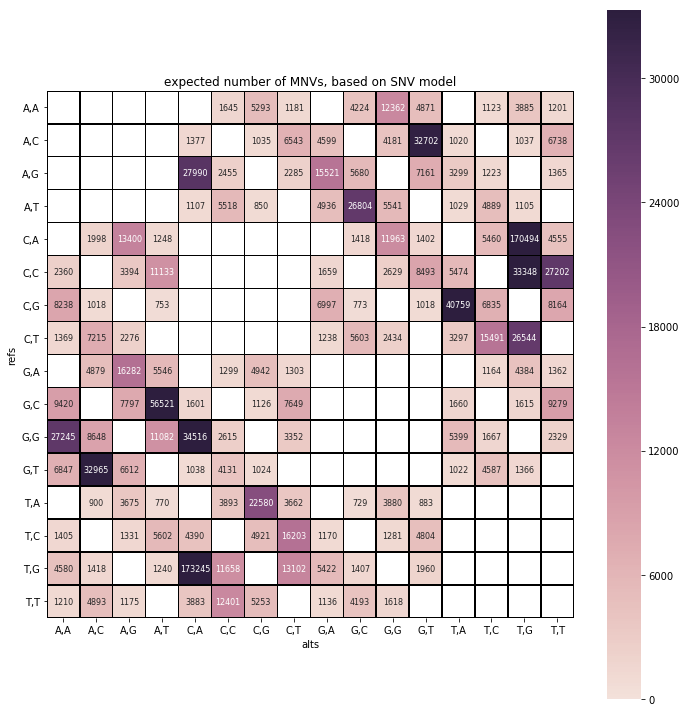

In [11]:
#simply look at the number, as heatmap
draw_heatmap(num_mat_dnv_null.applymap(lambda x: int(x)), "expected number of MNVs, based on SNV model")

Intuitively this look a lot similar to the real count, but let's actually check that our intuition are right by taking the correlation between the expected and observed frequency:

regression, log space:
slope, intercept, r_value, p_value, std_err = 
0.641499105927181 9.288550114176186 0.822947487027531 2.3956034973666837e-20 0.05079901164393801
regression, real space:
slope, intercept, r_value, p_value, std_err = 
984174278491.933 3972.816637874659 0.9542789299310672 1.323720451336412e-41 35362368657.831245


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


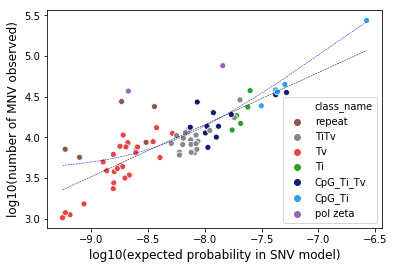

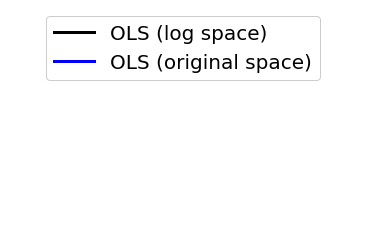

In [12]:
#take the linear regression in log space
import copy as cp
from scipy import stats
prob_null_coll = cp.copy(prob_mat_dnv_null) #collapsed.
prob_null_coll.index = prob_null_coll.index.str.replace(",","")
prob_null_coll.columns = prob_null_coll.index
prob_null_coll = collapse_crstb_to_revcomp(prob_null_coll)
prob_null_coll.index = prob_null_coll.refs + "->" + prob_null_coll.alts
dnv = dnv.sort_values(by="index")
out = pd.DataFrame({"cnt":dnv["cnt"], "prob":prob_null_coll["cnt"]})
out.index = prob_null_coll.index


#label each class, with different corresponding color
col_dict2={"CpG_Ti":"#2E9FFEFF","Ti":"#2ca02cff","Tv":"#EA4444ff","rep":"#8c564bFF","polz":"#9467bdff","mix":"#888888ff","CpG_NA":"#111e6cff"}
with hl.hadoop_open("gs://gnomad-public/release/2.1/mnv/resources/mnv_origin_classification.tsv", 'r') as f:
        cls = pd.read_csv(f,sep="\t") #just the classification of each MNV pattern
cls = cls["class_finer2"]
cls = cls.str.replace(" ","")
cls.fillna("mix", inplace=True)
cols = []
for i in range(len(cls)):
    cols.append(col_dict2[cls[i]])
legs = ["CpG_Ti","Ti","Tv","repeat","pol zeta","TiTv","CpG_Ti_Tv"]
out["color"] = cols
out["class_name"] = np.array(cls.str.replace("polz","pol zeta").str.replace("CpG_NA","CpG_Ti_Tv").str.replace("mix","TiTv").str.replace("rep","repeat"))

#plot
out["cnt_log10"] = np.log10(out["cnt"])
out["prob_log10"] = np.log10(out["prob"])
col_dict2={"CpG_Ti":"#2E9FFEFF","Ti":"#2ca02cff","Tv":"#EA4444ff","repeat":"#8c564bFF","pol zeta":"#9467bdff","TiTv":"#888888ff","CpG_Ti_Tv":"#111e6cff"}
palatte = {}
for l in legs:
    palatte[l] = col_dict2[l]

ax = sns.scatterplot(y="cnt_log10", x="prob_log10",
                 hue="class_name", data=out, palette=palatte)

#add regression slope
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(out.prob_log10),np.array(out.cnt_log10))
print ("regression, log space:")
print ("slope, intercept, r_value, p_value, std_err = ")
print (slope, intercept, r_value, p_value, std_err)
y_pred_ols_real = out.prob_log10*slope + intercept
ax.plot(out.prob_log10.sort_values(), y_pred_ols_real.sort_values(), color='black', linewidth=0.5, linestyle="--")
#real scale
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(out.prob),np.array(out.cnt))
print ("regression, real space:")
print ("slope, intercept, r_value, p_value, std_err = ")
print (slope, intercept, r_value, p_value, std_err)
y_pred_ols = np.log10(out.prob*slope + intercept)
ax.plot(out.prob_log10.sort_values(), y_pred_ols.sort_values(), color='blue', linewidth=0.5, linestyle="--")
ax.set_xlabel("log10(expected probability in SNV model)",fontname = "Microsoft Sans Serif", fontsize=12)
ax.set_ylabel("log10(number of MNV observed)",fontname = "Microsoft Sans Serif", fontsize=12)
plt.show()
#legend, as a separate plot
plt.plot([0,0], [1,1],color="#000000ff",label="OLS (log space)")
plt.plot([0,0], [1,1],color="#0000ffff",label="OLS (original space)")
leg = plt.legend(loc="upper left", fontsize=20, framealpha=1)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
plt.axis('off')
plt.show()

Indeed, we can see that they are on average in very good correlation. 

More exciting fact is that indeed, those that most deviate from the expected line (=upper left) are the ones known as pol zeta or repeat signature. 

Let's actually dig into those class of MNV patterns a bit more:

## Mechanism 2. DNA polymerase-zeta replication error

(Although indirect,) one possible way of observing the pol-zeta signature is by looking at the allele frequency of the component SNVs of an MNV.
(pol-zeta signature should have allele count1 ~= allele count 2).

We can simply check this. 

As a first step, let's get the count for those "one-step" MNVs:


In [13]:
mnvs = mnvs.annotate(onestep = (mnvs.ac1==mnvs.ac2))
mnvs.show(5)

locus,refs,alts,distance,snp1,snp2,ac1,ac2,ac_mnv,ac1_adj,ac2_adj,ac_mnv_adj,onestep
locus<GRCh37>,str,str,int32,str,str,int32,int32,int32,int32,int32,int32,bool
1:10247,"""T,A""","""C,T""",1,"""1-10247-T-C""","""1-10248-A-T""",23,19,4,3,3,0,false
1:14409,"""G,C""","""A,A""",1,"""1-14409-G-A""","""1-14410-C-A""",1,1,1,1,1,1,true
1:17928,"""T,C""","""A,A""",1,"""1-17928-T-A""","""1-17929-C-A""",190,190,190,18,17,16,true
1:23357,"""C,A""","""A,G""",1,"""1-23357-C-A""","""1-23358-A-G""",326,326,326,46,48,46,true
1:28592,"""T,T""","""G,G""",1,"""1-28592-T-G""","""1-28593-T-G""",2008,2000,2000,25,19,19,false


In [14]:
h_onestep = get_cnt_matrix(mnvs.filter(mnvs.onestep), dist=1)
pds_onestep = ht_cnt_mat_to_pd(h_onestep)
pds_onestep.index = pds_onestep.index.str.replace(",","")
pds_onestep.columns = pds_onestep.columns.str.replace(",","")
dnv_onestep = collapse_crstb_to_revcomp(pds_onestep) #this function to collapse the reverse complement, is defined in the end
#dnv_onestep = dnv_onestep.sort_values(by="cnt").reset_index()
names = dnv_onestep.refs + "->" + dnv_onestep.alts
dnv_onestep.index = names
dnv_onestep.head()

2019-04-10 04:53:52 Hail: INFO: Ordering unsorted dataset with network shuffle


,refs,alts,cnt
AA->CC,AA,CC,1660.0
AA->CG,AA,CG,1178.0
AA->CT,AA,CT,2914.0
AA->GC,AA,GC,5208.0
AA->GG,AA,GG,4448.0


now we can get the fraction of one-step MNVs for each MNV pattern:

In [15]:
frac_onestep = dnv_onestep.cnt/dnv.cnt
dnv.cnt
print (frac_onestep.head())

#and also the total:
#note that this total is slightly different from the paper -- in the paper we have used chr1 only, to match the number with other classes and highlight the error bar
#however the results are pretty much consistent, as we see in the figure below
frac_onestep_total = dnv_onestep.cnt.sum() /dnv.cnt.sum()
print ("total: {0}".format(frac_onestep_total))

AA->CC    0.231844
AA->CG    0.181566
AA->CT    0.650737
AA->GC    0.532352
AA->GG    0.240316
Name: cnt, dtype: float64
total: 0.3907833077827533


In [16]:
#standard error of the mean
errs = np.sqrt(frac_onestep * (1-frac_onestep) / dnv.cnt)
errs_total = np.sqrt(frac_onestep_total*(1-frac_onestep_total)/dnv.cnt.sum())

And visualize it (Fig 3C)

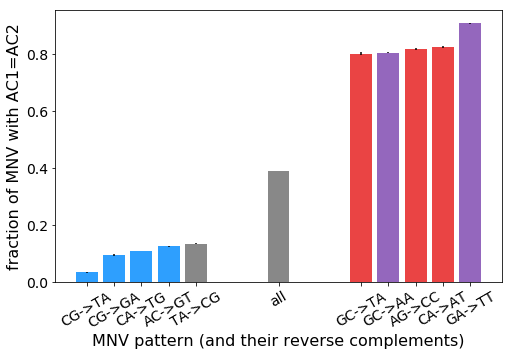

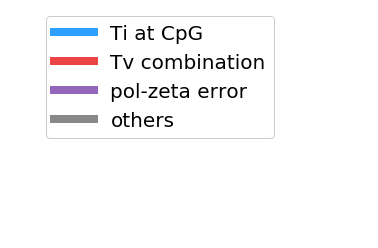

In [17]:
#plot:
df = pd.concat([frac_onestep, errs], axis=1)
df.columns = ["frac_onestep","err"]
df.sort_values(by="frac_onestep", inplace=True)
toplot = pd.concat([df.head(5), pd.DataFrame({"frac_onestep":frac_onestep_total, "err":errs_total}, index=["all"]), df.tail(5)])
#simple plot the top and bottom five
col_dict={"CpG_Ti":"#2E9FFEff","Ti":"#2ca02cff","Tv":"#EA4444FF","rep":"#8c564bFF","polzeta":"#9467bdFF","others":"#888888ff"}#re-defining the colors dictionary for this section
cols_class=["CpG_Ti","CpG_Ti","CpG_Ti","CpG_Ti","others","others","Tv","polzeta","Tv","Tv","polzeta"]
cols = []
for c in cols_class:
    cols.append(col_dict[c])
x = [1,2,3,4,5,8,11,12,13,14,15]
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.bar(x, toplot.frac_onestep, yerr = toplot.err, color=cols)
plt.xticks(x, toplot.index.values, fontname="Microsoft Sans Serif", rotation=30, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNV with AC1=AC2", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("MNV pattern (and their reverse complements)", fontname="Microsoft Sans Serif", size=16)
plt.show()


#just to add legend, outside of the figure:
plt.plot([0,0], [1,1],color=col_dict["CpG_Ti"],label="Ti at CpG")
plt.plot([0,0], [1,1],color=col_dict["Tv"],label="Tv combination")
plt.plot([0,0], [1,1],color=col_dict["polzeta"],label="pol-zeta error")
plt.plot([0,0], [1,1],color=col_dict["others"],label="others")
leg = plt.legend(loc="upper left", fontsize=20, framealpha=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
plt.axis('off')
plt.show()

It is almost obvious that there is a statistically significant difference, 
but of course we can simply show it by standard fisher exact test:

In [18]:
#statistical test:
from scipy import stats
def fisher_OR_and_pval(x1, x2, y1, y2): #1 case, 1 alt, 2 case, 2 alt
    oddsratio, pvalue = stats.fisher_exact([[x1, x2], [y1, y2]])
    return (oddsratio, pvalue)

(x1,x2) = (dnv_onestep.loc["GA->TT","cnt"],dnv.loc["GA->TT","cnt"])#GA->TT
(y1,y2) = (dnv_onestep.cnt.sum(),dnv.cnt.sum())
(OR, pval) = fisher_OR_and_pval(x1, x2, y1, y2)
print (OR, pval)

2.3233179223290703 0.0


## Mechanism 3. Polimerase slippage at repeat junctions

Finally, one of the (indirect) way of capturing MNVs that are presumably generated by polymerase slippage at repeat junctions is, 
to look at the fraction of MNVs that fall into repetitive contexts.
(If the fraction is higher, we think the fraction of MNVs being generated by such mechanisms is also higher.)
(This is also supported by the previous researches on mutation rate in repetitive contexts, 
 and also the difference in observed vs expected number of MNVs in those MNV patterns. See the main article for more discussion)

### Defining repetitive region

We appreciate the fact that there is a limitation in binary classification of repetitive or not, 
where in reality it should be discussed as a spectrum of repetitiveness. 
However, in order to capture enrichment, binary classification works very well.

Here we have the pre-calculated number of MNVs falling in repetitive contexts, 
defined by the number of mono/di-nucleotide repeats in +-4 bp context:

In [19]:
#load the fraction of repetitive MNV, pre-calculated up to 10bp.
with hl.hadoop_open("gs://gnomad-public/release/2.1/mnv/resources/frac_rep.tsv", 'r') as f:
        frac_rep = pd.read_csv(f,sep="\t", index_col=0)
frac_rep = frac_rep.iloc[:,0] #we only need distance=1 for now
frac_rep.index = frac_rep.index.str.replace(",","") #to match the others
display(frac_rep.head())

AA->CC    0.580587
AA->CG    0.136868
AA->CT    0.165029
AA->GC    0.120106
AA->GG    0.236317
Name: 1, dtype: float64

### Visualizing the fraction of MNVs in repetitive contexts (Fig. 3d)

Now we can visualize the fraction of MNVs falling in repetitive context, 
and do the statistical tests, just as we did in the one-step MNVs:

(In the manuscript, this is further confirmed by visualizing the bits logo.
Although this is out of the scope of this tutorial, users can replicate this by [ggseqlogo package](https://cran.r-project.org/web/packages/ggseqlogo/index.html) in R.)

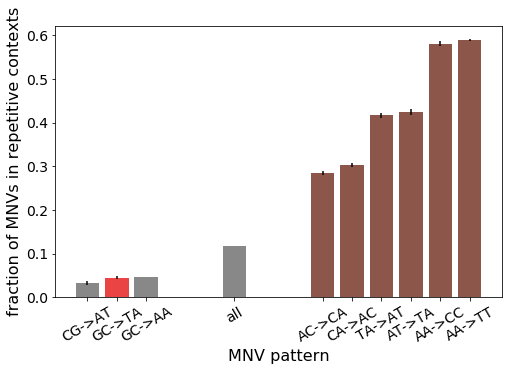

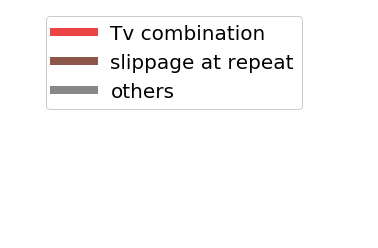

In [20]:
#visualize MNV

##get the fraction and error etc
err_rep = np.sqrt(frac_rep * (1-frac_rep) / dnv.sort_values(by="index").cnt)
cnt_rep = frac_rep * dnv.sort_values(by="index").cnt #to get the error bar
frac_rep_all = cnt_rep.sum() / dnv.sort_values(by="index").cnt.sum() #for all the MNVs combined
err_rep_all = np.sqrt(frac_rep_all * (1-frac_rep_all) / dnv.sort_values(by="index").cnt.sum())#for all the MNV combined

##concatinate as a dataframe for plotting
agg = pd.concat([frac_rep, pd.Series(err_rep)], axis=1)
agg.columns = ["mean","err"]
agg.sort_values(by="mean", inplace=True)
aggall = pd.concat([pd.Series(frac_rep_all), pd.Series(err_rep_all)], axis=1)
aggall.columns = ["mean","err"]
aggall.index = ["all"]

##plot
toplot = agg.head(3).append(aggall).append(agg.tail(6)) #plotting bottom 3 and top 3, as in the main figure 
cols_class = ["others","Tv","others","others"]+["rep"]*6
cols = []
for c in cols_class:
    cols.append(col_dict[c])
x = [2,3,4,7,10,11,12,13,14,15]
plt.figure(figsize=(8,5))
plt.bar(x, toplot["mean"], yerr=toplot["err"], color=cols) #dummy color
plt.xticks(x, toplot.index.values, fontname="Microsoft Sans Serif", rotation=30, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("fraction of MNVs in repetitive contexts", fontname="Microsoft Sans Serif", size=16)
plt.xlabel("MNV pattern", fontname="Microsoft Sans Serif", size=16)
plt.show()

##just to add legend, outside of the figure:

plt.plot([0,0], [1,1],color=col_dict["Tv"],label="Tv combination")
plt.plot([0,0], [1,1],color=col_dict["rep"],label="slippage at repeat")
plt.plot([0,0], [1,1],color=col_dict["others"],label="others")
leg = plt.legend(loc="upper left", fontsize=20, framealpha=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
plt.axis('off')
plt.show()

## quantification of mechanisms 1~3 (Fig 4. a)

The next step after confirming the enrichment signals are to quantify the contribution of different mechanisms, 
for each MNV pattern.

In order to do this, we took the simplest approach of 
1. For the MNVs that are above the repetitiveness threshold, we assume that the true mechanism is mechanism 3 (repeat)
2. Calculate the relative number of MNVs after excluding repetitive ones, assuming existence of only mechanism 1 (SNV combination)
(Assuming that for CA->TG, mechanism 1 dominates.)
3. Assume the rest is due to mechanism 2 (pol zeta, or any other error mode)

(For more discussion, please see the manuscript)

With all the data we have used so far, this can be done as follows:
(Using the plot function we defined in the bottom)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passi

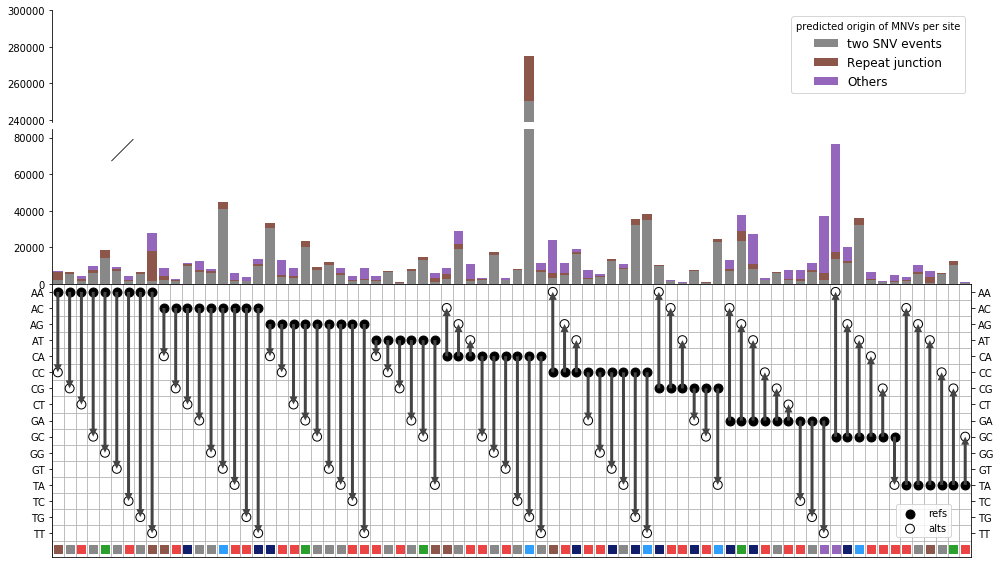

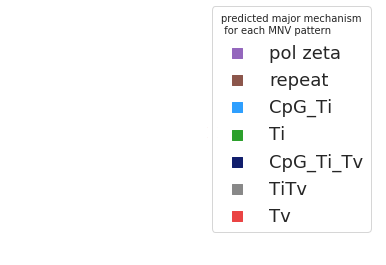

In [21]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from pylab import *

#first, get the predicted MNV origin classification for all the 78 patterns (e.g. Ti in CpG, pol zeta signature...)
with hl.hadoop_open("gs://gnomad-public/release/2.1/mnv/resources/mnv_origin_classification.tsv", 'r') as f:
         cls = pd.read_csv(f,sep="\t")
cls = cls["class_finer2"] #Here we will classify each MNV pattern with finer scale (e.g. TiTv is different from TvTv)
cls = cls.str.replace(" ","")
cls.fillna("mix", inplace=True)
#then re-map the colors.
col_dict2={"CpG_Ti":"#2E9FFEFF","Ti":"#2ca02cff","Tv":"#EA4444ff","rep":"#8c564bFF","polz":"#9467bdff","mix":"#888888ff","CpG_NA":"#111e6cff"}
cols = []
for i in range(len(cls)):
    cols.append(col_dict2[cls[i]])
legs = ["CpG_Ti","Ti","Tv","repeat","pol zeta","TiTv","CpG_Ti_Tv"]

#collapse the reverse complements, for the probability matrix calculated based on SNV mutation model
prob_mat_dnv_null.index = prob_mat_dnv_null.index.str.replace(",","")
prob_mat_dnv_null.columns = prob_mat_dnv_null.index
prob_mat_dnv_null_coll = collapse_crstb_to_revcomp(prob_mat_dnv_null)
prob_mat_dnv_null_coll.index = prob_mat_dnv_null_coll.refs + "->" + prob_mat_dnv_null_coll.alts

#the total count
cnt_mat = dnv

#the number of repeats, and non repeats
num_rep = cnt_rep
nonrep = (cnt_mat.cnt-num_rep) 

#the expected number of each MNV pattern counts, based purely on SNV mutational model, after subtracting the repeats
expected = (prob_mat_dnv_null_coll.cnt) * (nonrep["CA->TG"] / prob_mat_dnv_null_coll.cnt["CA->TG"])

#now calculate the contribution of "other" factors:
# if expected + num_rep < cnt_mat, then fill by "others" (others + expected + num_rep = cnt_mat)
# else force to expected + num_rep = cnt_mat
others = cnt_mat.cnt - num_rep -expected
others[(expected + num_rep) > cnt_mat.cnt] = 0
n_snp = expected
n_snp[n_snp>cnt_mat.cnt-num_rep] = nonrep[n_snp>cnt_mat.cnt-num_rep]

#finally we can plot everything:
plt.figure(figsize=(14,8))
plot_dnvcnt_fig(n_snp, others, num_rep)
plt.show()

#legend (ad hok but works..):
legs = ["CpG_Ti","Ti","Tv","repeat","pol zeta","CpG_Ti_Tv","TiTv"]
myorder = [4,3,0,1,6,5,2]
colns_beforeorder = list(col_dict2.values())
colns = [colns_beforeorder[i] for i in myorder]
legs = ["pol zeta","repeat","CpG_Ti","Ti","CpG_Ti_Tv","TiTv","Tv"]
sns.set_style("white")
fig, ax = plt.subplots()
for i in range(len(legs)):
    ax.scatter(0,0,color=colns[i],label=legs[i], marker="s", s=100)
ax.scatter(0,0,color="#ffffffff", marker="s", s=100) #to mask the unneeded dot
ax.legend(loc="lower right", title="predicted major mechanism\n for each MNV pattern", prop={'size': 18})
plt.axis('off')
plt.show()

## Analysis for MNV of distance >2

We can do the same analysis, such as the fraction of one-step MNVs, for any larger distance.

Here we will use pre-calcuated (by hail) dataframe up to distance 10:

(For the code for calculation in hail, please visit the `util` folder in the github.)

### example 1. fraction of MNVs in repetetive contexts, up to 10 bp distance

Remembering that we have pre-calculated list of fraction for up to 10 bp, we can visualize it using heatmap:

In [22]:
#(re-) load the fraction of repetitive MNV, pre-calculated up to 10bp.
with hl.hadoop_open("gs://gnomad-public/release/2.1/mnv/resources/frac_rep.tsv", 'r') as f:
        frac_rep = pd.read_csv(f,sep="\t", index_col=0)
frac_rep.head()

,1,2,3,4,5,6,7,8,9,10
"A,A->C,C",0.580587,0.564913,0.712228,0.668047,0.746751,0.671881,0.674191,0.716344,0.623136,0.705340
"A,A->C,G",0.136868,0.102782,0.147710,0.063086,0.164813,0.118771,0.203782,0.079826,0.157258,0.121005
"A,A->C,T",0.165029,0.139403,0.203155,0.138937,0.260322,0.254587,0.355923,0.216765,0.252888,0.243323
"A,A->G,C",0.120106,0.091642,0.127825,0.076544,0.167647,0.107051,0.177478,0.078934,0.150282,0.119518
"A,A->G,G",0.236317,0.326937,0.182010,0.350149,0.199323,0.271305,0.183210,0.312758,0.152601,0.257573


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


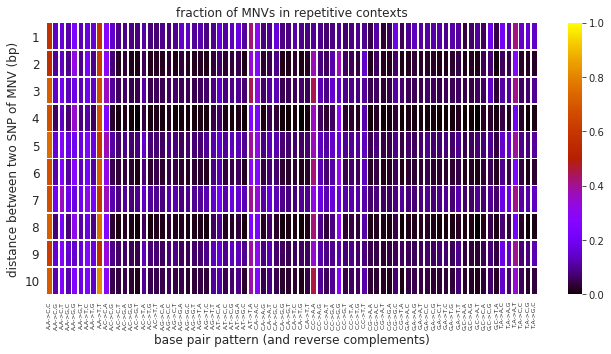

In [23]:
#plot as a heatmap
fig, ax = plt.subplots()
fig.set_size_inches(11,5)
ax = sns.heatmap(frac_rep.transpose() , vmin=0, vmax=1,
                 linewidths=.5, annot=False, cmap="gnuplot", xticklabels=True)
ax.set_title("fraction of MNVs in repetitive contexts", fontname = "Microsoft Sans Serif", size=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontname = "Microsoft Sans Serif", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontname = "Microsoft Sans Serif", size=6)
ax.set_ylabel("distance between two SNP of MNV (bp)", fontname = "Microsoft Sans Serif", size=12)
ax.set_xlabel("base pair pattern (and reverse complements)", fontname = "Microsoft Sans Serif", size=12)
plt.show()


We can apply the same workflow for various different features such as filtering status, existence of homozygotes ..., 
(Workflow: Aggregation in hail -> Save as a dataframe -> Plot using seaborn)

Below is another example following that workflow:

### example 2. Symmetry
For this, we show that we can actually check the symmetry between an MNV substitution pattern and its reverse complement, 
using the publicly available data of MNV of distance >1bp we provide:

2019-04-10 04:54:05 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:10 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:12 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:19 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:21 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:23 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:25 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:28 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-04-10 04:54:31 Hail: INFO: Ordering unsorted dataset with network shuffle


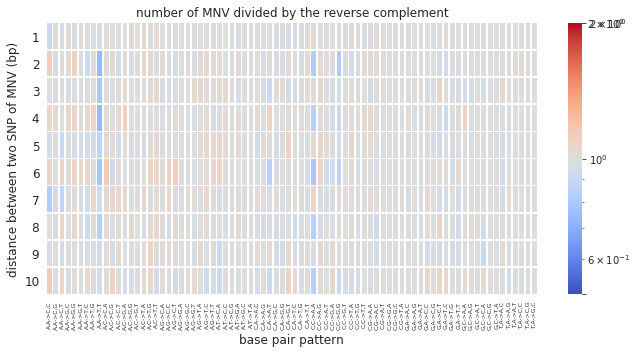

In [24]:
import hail.expr.aggregators as agg
df = [] #to put the data
for d in range(1,10+1): #for each distance
    d1 = hl.read_table("gs://gnomad-public/release/2.1/mnv/genome/gnomad_mnv_genome_d{0}.ht".format(d))#read the table
    d1 = get_cnt_matrix(d1, dist=d) #turn it to count matrix
    d1 = ht_cnt_mat_to_pd(d1) #turn it to pandas table
    t = calc_symmetry_and_collapse(d1) #calculate the symmetry
    t.index = t.index.str.replace("N", "")
    df.append(t) #and save it for that specific distance
df = pd.concat(df, axis=1)
df.columns = df.columns + 1 #index=0 -> distance=1

#and plot
from matplotlib.colors import LogNorm
log_norm = LogNorm(vmin=0.5, vmax=2)
cbar_ticks = [0.5,1,2]
fig, ax = plt.subplots()
fig.set_size_inches(11,5)
ax = sns.heatmap(df.transpose() , vmin=0.5, vmax=2,
                 linewidths=.5, annot=False, cmap="coolwarm",
                 norm=log_norm,
                 cbar_kws={"ticks": cbar_ticks}, xticklabels=True
                 )
ax.set_title("number of MNV divided by the reverse complement", fontname = "Microsoft Sans Serif", size=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontname = "Microsoft Sans Serif", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontname = "Microsoft Sans Serif", size=6)
ax.set_ylabel("distance between two SNP of MNV (bp)", fontname = "Microsoft Sans Serif", size=12)
ax.set_xlabel("base pair pattern", fontname = "Microsoft Sans Serif", size=12)
plt.show()

All the other heatmaps we see in the supplementary data of the manuscript follows the same workflow.
(Thus we will not re-generate every single figure there, but interested users can find the raw code in `util` folder.)

Let us conclude the section by final, one more example that involves same workflow but different visualization.

### example 3. Allele count distribution

We calculated the fraction of one-step MNVs in example 1, but have no information about the allele count distribution (e.g. are they mainly singleton? Do they really typically match the allele frequency of corresponding MNV?)

We will visualize this (=supplementary fig 15) using 3d plot:
(restricting to chr22, to let it be not too dense)

starting 1


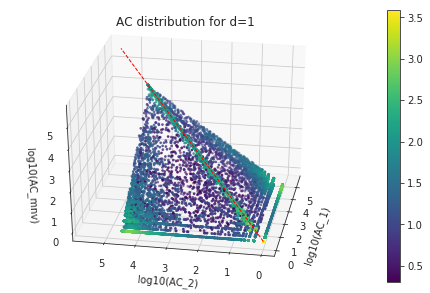

starting 2


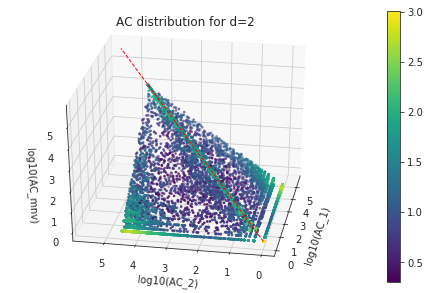

starting 3


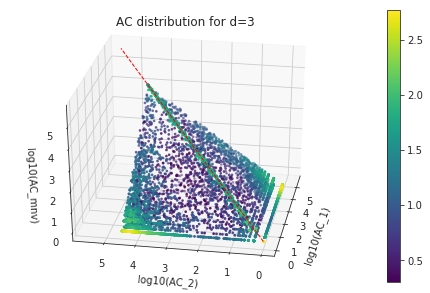

starting 4


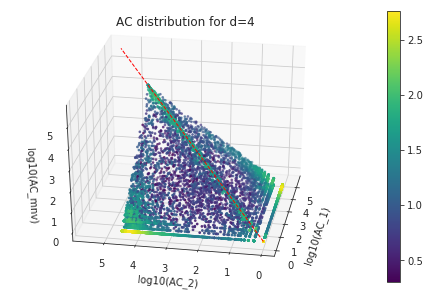

starting 5


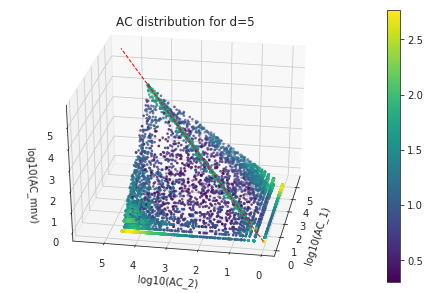

starting 6


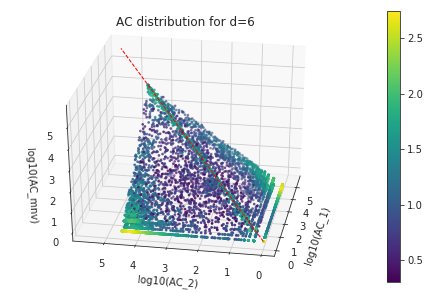

starting 7


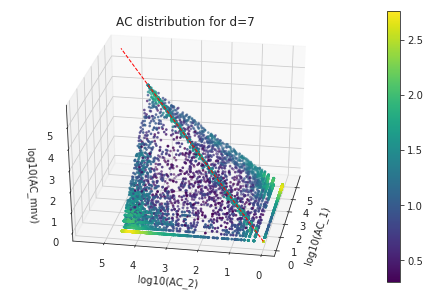

starting 8


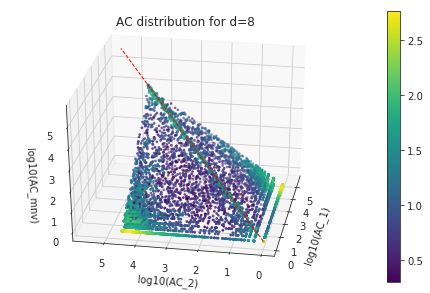

starting 9


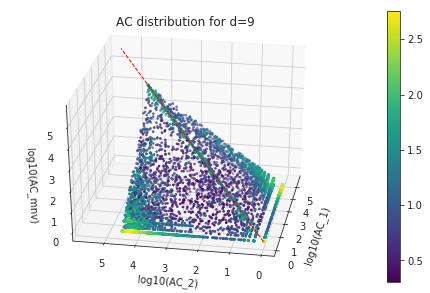

starting 10


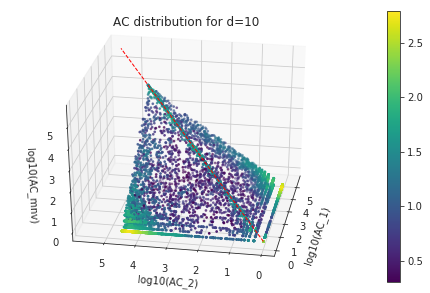

In [28]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

#define a custom density function
def num_around_in_log(x,y,z,df=df,thres=0.2): #thres=radius in log space
    return(df[((np.log10(x)-np.log10(df.ac1))**2 + (np.log10(y)-np.log10(df.ac2))**2 + (np.log10(z)-np.log10(df.ac_mnv))**2) < thres**2].shape[0])


for i in range(1,11):
    print ("starting {0}".format(i))
    d = hl.read_table("gs://gnomad-public/release/2.1/mnv/genome/gnomad_mnv_genome_d{0}.ht".format(i))#read the table
    df = d.to_pandas() #this is computationally heavy but we do this for custom density function used for better visualization
    df = df[df["locus.contig"]=="22"]
    cnt = df.apply(lambda l: num_around_in_log(l["ac1"], l["ac2"], l["ac_mnv"], thres=0.2, df=df),axis=1)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(np.log10(df['ac1']), np.log10(df['ac2']), np.log10(df['ac_mnv']),
               c=np.log10(cnt+1), cmap=cm.viridis,s=3) #log transformation is always the best?
    ax.plot([0,5.6], [0,5.6], [0,5.6], color = 'r', linewidth=1, linestyle="--")
    fig.colorbar(p)
    ax.view_init(30, 190)
    ax.set_zlabel("log10(AC_mnv)", fontname="Microsoft Sans Serif", size=10, rotation=-90)
    ax.set_xlabel("log10(AC_1)", fontname="Microsoft Sans Serif", size=10)
    ax.set_ylabel("log10(AC_2)", fontname="Microsoft Sans Serif", size=10)
    plt.title("AC distribution for d={0}".format(i))
    plt.show()


# end notes

- In this tutorial, we used the list of MNV in 15,708 genomes from gnomAD dataset to explore the global mechanisms of MNV. 
- Finally in the next tutorial, stepping from the "global" mechanism, we will dive into the difference between different region in the genome.

In [26]:
# Functions 

comp = {}
comp["A"] = "T"
comp["T"] = "A"
comp["G"] = "C"
comp["C"] = "G"
comp["N"] = "N"
comp[","] = ","

def revcomp(seq):
    out = ""
    for i in seq[::-1]:
        out = out + comp[i]
    return (out)

def collapse_crstb_to_revcomp(crstb):
    # collaspse to a table, instead of another matrix
    flt = crstb.stack().reset_index()
    flt.columns = ['refs', 'alts', 'cnt']
    for i in range(flt.shape[0]):
        if i in flt.index:  # if it hasn't been deleted yet
            refs_revcomp = revcomp(flt.refs[i])
            alts_revcomp = revcomp(flt.alts[i])
            ix_revcomp = flt[(flt.refs == refs_revcomp) & (flt.alts == alts_revcomp)].index[0]
            if i != ix_revcomp:  # if revcomp is not yourself
                flt.loc[i, "cnt"] = flt.loc[i, "cnt"] + flt.loc[ix_revcomp, "cnt"]
                flt.drop(ix_revcomp, inplace=True)
    flt = flt[flt.cnt > 0]  # deleting the no dNVs
    flt.reset_index(inplace=True)
    del flt["index"]
    return (flt)

def calc_symmetry_and_collapse(crosstab):
    sym = []
    names = []
    for i in range(crosstab.shape[0]):
        for j in range(crosstab.shape[1]):
            refs = crosstab.index[i]
            alts = crosstab.index[j]
            if crosstab.loc[refs,alts]!=0:
                revcomp_refs = revcomp(refs)
                revcomp_alts = revcomp(alts)
                if not ((revcomp_refs + "->" + revcomp_alts) in names):
                        sym.append(crosstab.loc[refs, alts] / crosstab.loc[revcomp_refs, revcomp_alts])
                        names.append(refs + "->" + alts)
    return pd.Series(sym,index=names)


#defining the broken axes class
#which is taken directly from https://github.com/bendichter/brokenaxes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import rcParams
from datetime import timedelta
import numpy as np

__author__ = 'Ben Dichter' #the author of this package


class BrokenAxes:
    def __init__(self, xlims=None, ylims=None, d=.015, tilt=45,
                 subplot_spec=None, fig=None, despine=True,
                 xscale=None, yscale=None, diag_color='k',
                 *args, **kwargs):
        """Creates a grid of axes that act like a single broken axes
        
        Parameters
        ----------
        xlims, ylims: (optional) None or tuple of tuples, len 2
            Define the ranges over which to plot. If `None`, the axis is left
            unsplit.
        d: (optional) double
            Length of diagonal split mark used to indicate broken axes
        tilt: (optional) double
            Angle of diagonal split mark
        subplot_spec: (optional) None or Gridspec.subplot_spec
            Defines a subplot
        fig: (optional) None or Figure
            If no figure is defined, `plt.gcf()` is used
        despine: (optional) bool
            Get rid of right and top spines. Default: True
        wspace, hspace: (optional) bool
            Change the size of the horizontal or vertical gaps
        xscale, yscale: (optional) None | str
            None: linear axis (default), 'log': log axis
        diag_color: (optional)
            color of diagonal lines
        args, kwargs: (optional)
            Passed to gridspec.GridSpec
            
        Notes
        -----
        The broken axes effect is achieved by creating a number of smaller axes
        and setting their position and data ranges. A "big_ax" is used for
        methods that need the position of the entire broken axes object, e.g.
        `set_xlabel`.
        """

        self.diag_color = diag_color
        self.despine = despine
        self.d = d
        self.tilt = tilt

        if fig is None:
            self.fig = plt.gcf()
        else:
            self.fig = fig

        if xlims:
            # Check if the user has asked for a log scale on x axis
            if xscale == 'log':
                width_ratios = [np.log(i[1]) - np.log(i[0]) for i in xlims]
            else:
                width_ratios = [i[1] - i[0] for i in xlims]
        else:
            width_ratios = [1]

        # handle datetime xlims
        if type(width_ratios[0]) == timedelta:
            width_ratios = [tt.total_seconds() for tt in width_ratios]

        if ylims:
            # Check if the user has asked for a log scale on y axis
            if yscale == 'log':
                height_ratios = [np.log(i[1]) - np.log(i[0])
                                 for i in ylims[::-1]]
            else:
                height_ratios = [i[1] - i[0] for i in ylims[::-1]]
        else:
            height_ratios = [1]

        # handle datetime ylims
        if type(height_ratios[0]) == timedelta:
            width_ratios = [tt.total_seconds() for tt in height_ratios]

        ncols, nrows = len(width_ratios), len(height_ratios)

        kwargs.update(ncols=ncols, nrows=nrows, height_ratios=height_ratios,
                      width_ratios=width_ratios)
        if subplot_spec:
            gs = gridspec.GridSpecFromSubplotSpec(subplot_spec=subplot_spec,
                                                  *args, **kwargs)
            self.big_ax = plt.Subplot(self.fig, subplot_spec)
        else:
            gs = gridspec.GridSpec(*args, **kwargs)
            self.big_ax = plt.Subplot(self.fig, gridspec.GridSpec(1, 1)[0])

        [sp.set_visible(False) for sp in self.big_ax.spines.values()]
        self.big_ax.set_xticks([])
        self.big_ax.set_yticks([])
        self.big_ax.patch.set_facecolor('none')

        self.axs = []
        for igs in gs:
            ax = plt.Subplot(self.fig, igs)
            self.fig.add_subplot(ax)
            self.axs.append(ax)
        self.fig.add_subplot(self.big_ax)

        for i, ax in enumerate(self.axs):
            if ylims is not None:
                ax.set_ylim(ylims[::-1][i//ncols])
            if xlims is not None:
                ax.set_xlim(xlims[i % ncols])
        self.standardize_ticks()
        if d:
            self.draw_diags()
        if despine:
            self.set_spines()

    @staticmethod
    def draw_diag(ax, xpos, xlen, ypos, ylen, **kwargs):
        return ax.plot((xpos - xlen, xpos + xlen), (ypos - ylen, ypos + ylen),
                       **kwargs)

    def draw_diags(self):
        """
        
        Parameters
        ----------
        d: float
            Length of diagonal split mark used to indicate broken axes
        tilt: float
            Angle of diagonal split mark
        """
        size = self.fig.get_size_inches()
        ylen = self.d * np.sin(self.tilt * np.pi / 180) * size[0] / size[1]
        xlen = self.d * np.cos(self.tilt * np.pi / 180)
        d_kwargs = dict(transform=self.fig.transFigure, color=self.diag_color,
                        clip_on=False, lw=rcParams['axes.linewidth'])

        ds = []
        for ax in self.axs:
            bounds = ax.get_position().bounds

            if ax.is_last_row():
                ypos = bounds[1]
                if not ax.is_last_col():
                    xpos = bounds[0] + bounds[2]
                    ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                         **d_kwargs)
                if not ax.is_first_col():
                    xpos = bounds[0]
                    ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                         **d_kwargs)

            if ax.is_first_col():
                xpos = bounds[0]
                if not ax.is_first_row():
                    ypos = bounds[1] + bounds[3]
                    ds += self.draw_diag(ax, xpos, xlen, ypos, ylen, **d_kwargs)
                if not ax.is_last_row():
                    ypos = bounds[1]
                    ds += self.draw_diag(ax, xpos, xlen, ypos, ylen, **d_kwargs)

            if not self.despine:
                if ax.is_first_row():
                    ypos = bounds[1] + bounds[3]
                    if not ax.is_last_col():
                        xpos = bounds[0] + bounds[2]
                        ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                             **d_kwargs)
                    if not ax.is_first_col():
                        xpos = bounds[0]
                        ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                             **d_kwargs)

                if ax.is_last_col():
                    xpos = bounds[0] + bounds[2]
                    if not ax.is_first_row():
                        ypos = bounds[1] + bounds[3]
                        ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                             **d_kwargs)
                    if not ax.is_last_row():
                        ypos = bounds[1]
                        ds += self.draw_diag(ax, xpos, xlen, ypos, ylen,
                                             **d_kwargs)
        self.diag_handles = ds

    def set_spines(self):
        """Removes the spines of internal axes that are not boarder spines.
        """
        for ax in self.axs:
            ax.xaxis.tick_bottom()
            ax.yaxis.tick_left()
            if not ax.is_last_row():
                ax.spines['bottom'].set_visible(False)
                plt.setp(ax.xaxis.get_minorticklabels(), visible=False)
                plt.setp(ax.xaxis.get_minorticklines(), visible=False)
                plt.setp(ax.xaxis.get_majorticklabels(), visible=False)
                plt.setp(ax.xaxis.get_majorticklines(), visible=False)
            if self.despine or not ax.is_first_row():
                ax.spines['top'].set_visible(False)
            if not ax.is_first_col():
                ax.spines['left'].set_visible(False)
                plt.setp(ax.yaxis.get_minorticklabels(), visible=False)
                plt.setp(ax.yaxis.get_minorticklines(), visible=False)
                plt.setp(ax.yaxis.get_majorticklabels(), visible=False)
                plt.setp(ax.yaxis.get_majorticklines(), visible=False)
            if self.despine or not ax.is_last_col():
                ax.spines['right'].set_visible(False)

    def standardize_ticks(self, xbase=None, ybase=None):
        """Make all of the internal axes share tick bases
        
        Parameters
        ----------
        xbase, ybase: (optional) None or float
            If `xbase` or `ybase` is a float, manually set all tick locators to
            this base. Otherwise, use the largest base across internal subplots
            for that axis.
        """
        if xbase is None:
            if self.axs[0].xaxis.get_scale() == 'log':
                xbase = max(ax.xaxis.get_ticklocs()[1] /
                            ax.xaxis.get_ticklocs()[0]
                            for ax in self.axs if ax.is_last_row())
            else:
                xbase = max(ax.xaxis.get_ticklocs()[1] -
                            ax.xaxis.get_ticklocs()[0]
                            for ax in self.axs if ax.is_last_row())
        if ybase is None:
            if self.axs[0].yaxis.get_scale() == 'log':
                ybase = max(ax.yaxis.get_ticklocs()[1] /
                            ax.yaxis.get_ticklocs()[0]
                            for ax in self.axs if ax.is_first_col())
            else:
                ybase = max(ax.yaxis.get_ticklocs()[1] -
                            ax.yaxis.get_ticklocs()[0]
                            for ax in self.axs if ax.is_first_col())

        for ax in self.axs:
            if ax.is_first_col():
                if ax.yaxis.get_scale() == 'log':
                    ax.yaxis.set_major_locator(ticker.LogLocator(ybase))
                else:
                    ax.yaxis.set_major_locator(ticker.MultipleLocator(ybase))
            if ax.is_last_row():
                if ax.xaxis.get_scale() == 'log':
                    ax.xaxis.set_major_locator(ticker.LogLocator(xbase))
                else:
                    ax.xaxis.set_major_locator(ticker.MultipleLocator(xbase))

    def __getattr__(self, method):
        """Catch all methods that are not defined and pass to internal axes
         (e.g. plot, errorbar, etc.).
        """
        return CallCurator(method, self)

    def subax_call(self, method, args, kwargs):
        """Apply method call to all internal axes. Called by CallCurator.
        """
        result = []
        for ax in self.axs:
            if ax.xaxis.get_scale() == 'log':
                ax.xaxis.set_major_locator(ticker.LogLocator())
            else:
                ax.xaxis.set_major_locator(ticker.AutoLocator())
            if ax.yaxis.get_scale() == 'log':
                ax.yaxis.set_major_locator(ticker.LogLocator())
            else:
                ax.yaxis.set_major_locator(ticker.AutoLocator())
            result.append(getattr(ax, method)(*args, **kwargs))

        self.standardize_ticks()
        self.set_spines()

        return result

    def set_xlabel(self, label, labelpad=15, **kwargs):
        return self.big_ax.set_xlabel(label, labelpad=labelpad, **kwargs)

    def set_ylabel(self, label, labelpad=30, **kwargs):
        self.big_ax.xaxis.labelpad = labelpad
        return self.big_ax.set_ylabel(label, labelpad=labelpad, **kwargs)

    def set_title(self, *args, **kwargs):
        return self.big_ax.set_title(*args, **kwargs)

    def legend(self, *args, **kwargs):
        h, l = self.axs[0].get_legend_handles_labels()
        return self.big_ax.legend(h, l, *args, **kwargs)

    def axis(self, *args, **kwargs):
        [ax.axis(*args, **kwargs) for ax in self.axs]


class CallCurator:
    """Used by BrokenAxes.__getattr__ to pass methods to internal axes."""
    def __init__(self, method, broken_axes):
        self.method = method
        self.broken_axes = broken_axes

    def __call__(self, *args, **kwargs):
        return self.broken_axes.subax_call(self.method, args, kwargs)


def brokenaxes(*args, **kwargs):
    """Convenience method for `BrokenAxes` class.
    
    Parameters
    ----------
    args, kwargs: passed to `BrokenAxes()`
    
    Returns
    -------
    out: `BrokenAxes`
    """
    return BrokenAxes(*args, **kwargs)


#function for figure 4a
def plot_dnvcnt_fig(n_snp, n_others, n_rep=np.zeros(78), bax_ylims=((-1, 85000), (239000,300000))):
    #n_snp = obs mat. DO need to explicitly pass the final number
    headv = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    # all the 78 patterns as v3
    ptns = n_snp.index
    v3 = pd.DataFrame(np.zeros([16, 78]))
    v3.index = headv
    v3.columns = ptns
    refs = v3.columns.str.split("->").str[0]
    alts = v3.columns.str.split("->").str[1]
    for j in range(len(refs)):
        ref = refs[j]
        alt = alts[j]
        col = v3.columns[j]
        v3.loc[ref, col] = 1  # from
        v3.loc[alt, col] = 2  # to
    arrow = []  # nothing at first
    for col in range(v3.shape[1]):
        for i in range(v3.shape[0]):
            if v3.iloc[i, col] == 1:
                # arrow_from = [i,col]
                arrow_from = [col, i]
            elif v3.iloc[i, col] == 2:
                # arrow_to = [i,col]
                arrow_to = [col, i]
        arrow.append(arrow_from + arrow_to)
    arrow = np.array(arrow)
    sps1, sps2 = GridSpec(2, 1)
    if bax_ylims=="NO":
        bax = brokenaxes(hspace=.05, subplot_spec=sps1)
    else:
        bax = brokenaxes(ylims=bax_ylims, hspace=.05, subplot_spec=sps1)
    bax.grid(axis='none')
    bax.bar(range(len(n_snp)), n_snp, color='#888888FF', label="two SNV events")  # observed
    bax.bar(range(len(n_snp)), n_rep, bottom=n_snp, color='#8c564bFF', label="Repeat junction")
    bax.bar(range(len(n_snp)), n_others,bottom=n_snp + n_rep, color='#9467bdff', label="Others") #expected. just overlay from the bottom

    bax.legend(loc="upper right", title="predicted origin of MNVs per site", fontsize="large")  # , framealpha=1)
    bax.set_xlim(-0.5, 78 - .5)
    bax.set_xticklabels([])
    ax = plt.subplot(sps2)  # , sharey=sps1)
    ax.set_xlim(-0.5, v3.shape[1] - .5)
    ax.set_ylim(-0.5, v3.shape[0] - .5 + 1)
    ax.invert_yaxis()
    for j in range(v3.shape[1]):
        ax.scatter(j, v3.shape[0], s=80, color=cols[j], marker="s")  # color corresponding to Tv etc class
        # adding the color for classification
    for i in range(v3.shape[0]):
        for j in range(v3.shape[1]):
            if v3.iloc[i, j] > 0:
                if v3.iloc[i, j] == 1:
                    if j == 0:
                        ax.scatter(j, i, s=80, color="black", label="refs")  # label first
                    else:
                        ax.scatter(j, i, s=80, color="black")
                elif v3.iloc[i, j] == 2:
                    if j == 0:
                        ax.scatter(j, i, s=80, color="black", facecolors="none", label="alts")
                    else:
                        ax.scatter(j, i, s=80, color="black", facecolors="none")
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(-0.5, v3.shape[1] - .5, 1)))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-0.5, v3.shape[1] - .5, 1)))
    plt.tick_params(axis='both', which='minor', bottom='off', top='off',
                    left="off", right="off", labelbottom='off', labelleft='off')
    plt.yticks(np.arange(16), headv)
    plt.xticks([])
    ax.tick_params(labeltop=False, labelright=True, right=True)
    ax.grid(True, which='minor')
    # arrow:
    arrowprops = dict(facecolor='#444444ff', alpha=1, lw=0,
                      shrink=0, width=3, headwidth=8, headlength=8)
    for i in range(arrow.shape[0]):
        ax.annotate("", xy=arrow[i, 2:], xytext=arrow[i, :2], arrowprops=arrowprops)
    plt.legend(loc="lower right", borderaxespad=2, bbox_to_anchor=(1, 0))
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

